# Exploring Boston Airbnb Data

## 1. Overview of the Data

In [1]:
# Import packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import calendar as cal

import geopy

import folium
from folium.plugins import MarkerCluster

In [2]:
# Import the data
calendar = pd.read_csv('./data/calendar.csv')
listings = pd.read_csv('./data/listings.csv')

### a. Calendar data

In [3]:
# Check the shape and components of the calendar data
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


In [4]:
calendar.head(2)

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN


In [5]:
calendar.tail(2)

,listing_id,date,available,price
1308888,14504422,2016-09-07,f,NaN
1308889,14504422,2016-09-06,f,NaN


In [6]:
calendar[calendar['available'] == 't'].head(2)

,listing_id,date,available,price
365,3075044,2017-08-22,t,$65.00
366,3075044,2017-08-21,t,$65.00


In [7]:
# Check if there's any missing values
def columns_with_null(df):
    '''
    Method to find columns with missing values
    
    Args:
        df: a Dataframe
        
    Returns:
        Dataframe: dataframe with column names, number of missing values, and percentage of missing values
    '''
    
    cols = df.columns[df.isnull().sum() > 0]
    df_null = pd.DataFrame(df[cols].isnull().sum().sort_values(), columns=['# of Nulls'])
    df_null['Null %'] = df[cols].isnull().mean().sort_values()
    return df_null

columns_with_null(calendar)

,# of Nulls,Null %
price,665853,0.508716


In [8]:
# Check if there's any wrong entry such that the price isn't null when the list is not available and vice versa
print(calendar[calendar['available'] == 'f']['price'].isnull().mean() == 1)
print(sum(calendar[calendar['available'] == 't']['price'].isnull()) == 0)

True
True


The data in calendar.csv includes theinformation about the avalability and price of the listings of Airbnb in Boston area for one year, from 2016-09-06 to 2017-09-05. Each enry includes the listing id, the date, and the availability of the listing property with the corresponding price at that date. <br/>
No missing value is found in the data except that about half of the entries have null values for the price, since the price information is unknown if the property is unavailable at that date.<br/>
Further information such as which time during the year are these properties most popular and which properties are most popular can be extracted later. Also, the format of the price and data columns need to be transformed. 

### b. Listings data

In [9]:
# Check the shape and components of the listings data
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [10]:
pd.set_option('display.max_columns', 100)
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United Sta

In [11]:
# Check the numeric columns
listings_num = listings.select_dtypes(include=['float64', 'int64'])
print('In total %d columns with numeric values.' % len(listings_num.columns))
listings_num.columns

In total 33 columns with numeric values.


Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'guests_included', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'jurisdiction_names',
       'calculated_host_listings_count', 'reviews_per_month'],
      dtype='object')

In [12]:
# Check if each entry for a unique id
listings.shape[0] == len(listings['id'].unique())

True

In [13]:
# Check if there's any missing values
columns_with_null(listings)

,# of Nulls,Null %
city,2,0.000558
property_type,3,0.000837
beds,9,0.002510
bedrooms,10,0.002789
host_location,11,0.003068
market,14,0.003905
bathrooms,14,0.003905
zipcode,38,0.010600
summary,143,0.039888
host_neighbourhood,339,0.094561


The data in listings.csv includes a lot of information about listings and each entry represents the information about a unique entry. There are in total 95 columns and 33 of these are numeric columns<br/>
Quite a few columns in the dataset have missing values. For columns of jurisdiction_names, license, neighbourhood_group_cleansed, and has_availability with 100% missing values, we can simply drop these columns, for other columns, further engineering is required.<br/>
Questions like in which area the prices of propties are higher and how the average ratings is related to other factors such as price and zipcode can be explored. In addition, the predictive model for price can be constructed based on the dataset.

## 2. Analysis of the Data

Before constructing a predictive model for Airbnb price in Bostan, we could further dig into the data and find the answers to some of the questions of interests like raised above.

### a. How the overall trend changes with time
In this section, we will explore how the average price of listed properties and the total number of available listed properties changes by month.

In [14]:
# Transform the format of date
calendar_cleaned = calendar.copy()
calendar_cleaned['date'] = pd.to_datetime(calendar_cleaned['date'], format='%Y-%m-%d')

def price_reformat(df, col):
    '''
    Method to re-format the price into a float, i.e. $1,305.00 (str) -> 1305.00 (float)
    
    Args:
        df: a Dataframe
        col: string, the name of the column to transform
        
    Returns:
        Dataframe: the datafram with the selected column re-formatted
    '''
    
    df[col] = df[col].str.replace('$', '').str.replace(',', '').astype(float)
    return df

calendar_cleaned = price_reformat(calendar_cleaned, 'price')

calendar_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   listing_id  1308890 non-null  int64         
 1   date        1308890 non-null  datetime64[ns]
 2   available   1308890 non-null  object        
 3   price       643037 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 39.9+ MB


We are interested in overall trend that how popular and price of the properties change with time. Fistyly, we have to group the data by time (here we choose to fistly group by month). 

In [15]:
# Create the column for month
calendar_cleaned['month'] = calendar_cleaned['date'].apply(lambda x: x.month)

In [16]:
# Group by month and calculate the corresponding availability and average price
calendar_avail = calendar_cleaned[calendar_cleaned['available'] == 't']
avail_by_month = calendar_avail.groupby('month')['available'].count().reset_index(name='counts').sort_values(by='month')
avail_by_month['month'] = avail_by_month['month'].apply(lambda x: cal.month_abbr[x])
price_by_month = calendar_avail.groupby('month')['price'].mean().reset_index(name='avg price').sort_values(by='month')
price_by_month['month'] = price_by_month['month'].apply(lambda x: cal.month_abbr[x])

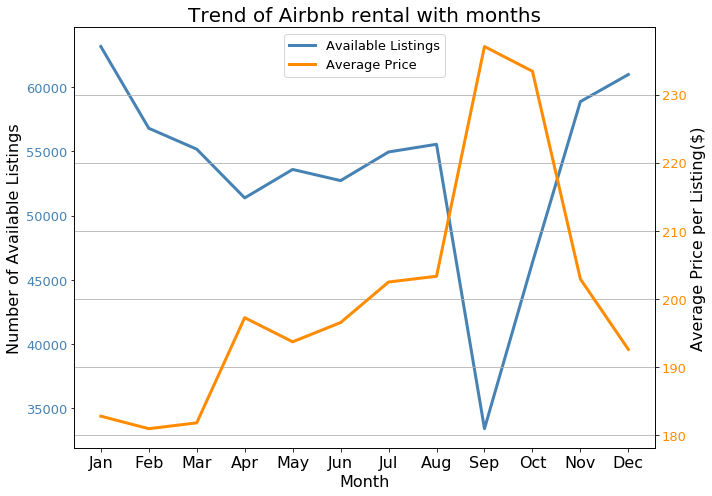

In [17]:
# Visualize the trend
fig, ax1 = plt.subplots(figsize=(10, 7))
# fig.suptitle('Trend of Airbnb rental with months', fontsize = 20)

ax1.set_xlabel('Month', fontsize = 16)
ax1.set_ylabel('Number of Available Listings', fontsize = 16)
l1 = ax1.plot(avail_by_month['month'], avail_by_month['counts'], color = 'steelblue', lw = 3, label = 'Available Listings')
ax1.set_title('Trend of Airbnb rental with months', fontsize = 20)
ax1.tick_params(axis='y', labelcolor='steelblue', labelsize = 13)
ax1.tick_params(axis='x', labelsize = 16)

ax2 = ax1.twinx()

ax2.set_ylabel('Average Price per Listing($)', fontsize = 16)
l2 = ax2.plot(price_by_month['month'], price_by_month['avg price'], color = 'darkorange', lw = 3, label = 'Average Price')
ax2.tick_params(axis='y', labelcolor='darkorange', labelsize = 13)

ls = l1+l2
labs = [l.get_label() for l in ls]
ax1.legend(ls, labs, loc = 'upper center', fontsize = 13)

plt.grid(True)
plt.tight_layout()
plt.savefig('./figs/time_trend.png', dpi = 300, bbox_inches='tight')
plt.show()

### How the overall statistcs of properties changes with location (zip code)?
In this section, we will explore how the average price, avearge rating, popularity of rentals, and number of listed properties change with location, as visualized on the map.

In [18]:
# Convert price to float
listings_cleaned = listings.copy()
listings_cleaned = price_reformat(listings_cleaned, 'price')

In [19]:
# Check if there's any missing/wrong entries for the listed properties during the period of one year
cal_by_id = calendar_cleaned.groupby('listing_id')['available'].count().reset_index(name='total')
cal_by_id['total'].value_counts()

365    3584
730       1
Name: total, dtype: int64

We can see that it seems that all entries for one property are duplicated, but this is going to be fine when we calculate the percentage of availability due the periode of one year, so we will keep this.

In [20]:
cal_avail_by_id = calendar_avail.groupby('listing_id')['available'].count().reset_index(name='avail')
cal_by_id = cal_by_id.merge(cal_avail_by_id, how='left', on='listing_id')

# Fill the null values with 0 since null here means no availability throughout the year
cal_by_id['avail'].fillna(value=0, inplace=True)

# Compute the availability rate
cal_by_id['non_avail_rate'] = cal_by_id['avail'] / cal_by_id['total']

In [21]:
# Rename the columns and drop unnecessary columns
cal_by_id.rename(columns={'listing_id':'id'}, inplace=True)
cal_by_id.drop(['total', 'avail'], axis=1, inplace=True)

In [22]:
# Add the column of the percentage of non-availability for each id
listings_cleaned = listings_cleaned.merge(cal_by_id, how='left', on='id')

In [23]:
# Check the missing values in columns we care about in this section asl well as for predicting price
listings_prd = listings_cleaned.loc[:, ['price', 'review_scores_rating', 'number_of_reviews', 'non_avail_rate', 'zipcode',
                                        'latitude', 'longitude', 'host_is_superhost', 'property_type', 'room_type',
                                        'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'guests_included',
                                        'extra_people', 'availability_30', 'availability_60', 'availability_90',
                                        'availability_365', 'instant_bookable', 'cancellation_policy',
                                        'require_guest_profile_picture', 'require_guest_phone_verification']]
columns_with_null(listings_prd)

,# of Nulls,Null %
property_type,3,0.000837
beds,9,0.002510
bedrooms,10,0.002789
bathrooms,14,0.003905
zipcode,38,0.010600
review_scores_rating,813,0.226778


Since we care about the ratings received for the listed properties and it's hard to impute the missing values for these rows, we'll remove these rows with missing ratings.

In [24]:
listings_prd.dropna(axis=0, subset=['review_scores_rating'], inplace=True)
listings_prd['review_scores_rating'].describe()

count    2772.000000
mean       91.916667
std         9.531686
min        20.000000
25%        89.000000
50%        94.000000
75%        98.250000
max       100.000000
Name: review_scores_rating, dtype: float64

In [25]:
# Use the latitude and longitude to find it
def coordinate_to_zipcode(df, lat=None, lon=None, zipcode=None, is_coordinate=True):
    '''
    Method to apply on a Dataframe to convert latitude and longitude to corresponding zipcode
    
    Args:
        df: a Datafram
        lat/lon/zipcode: string, the column name for the latitude/longitude/code
        is_coordinate: boolean, convert from coordinate to zipcode or vice versa
        
    Returns:
        Series: a series with the converted zipcode/(latitude and longitude)
    '''
    
    geolocator = geopy.Nominatim(user_agent='czh')
    
    if is_coordinate:
        loc = geolocator.reverse((df[lat], df[lon]))
        return loc.raw['address']['postcode']
    else:
        # Specify the country for querying
        loc = geolocator.geocode(df[zipcode], country_codes ='US')
        return (loc.latitude, loc.longitude)

In [26]:
# Get the corresponding value based on the coordinates for the rows with missing zipcode
zipcode_sub = listings_prd[listings_prd['zipcode'].isnull()].apply(coordinate_to_zipcode, 
                                                                   lat='latitude', lon='longitude', axis=1)
# Fill in the missing values
listings_prd['zipcode'].fillna(zipcode_sub, inplace=True)

In [27]:
listings_prd['zipcode'].value_counts()

02116          289
02130          283
02118          214
02114          176
02134          172
02127          160
02215          146
02128          137
02135          127
02115          124
02125          111
02119           88
02113           83
02120           78
02124           68
02129           67
02108           67
02111           65
02131           59
02210           52
02122           37
02109           36
02132           27
02136           23
02121           22
02126           18
02110           11
02145            5
02467            3
02143            3
02163            3
02130-0947       2
02446            2
02138            2
02141            2
02445            2
02131-3025       1
02199            1
02186            1
02134-1704       1
02139            1
02134-1433       1
02142            1
02108 02111      1
Name: zipcode, dtype: int64

In [28]:
# Remove the part after '-' in zipcode 
listings_prd.replace({'02130-0947':'02130',
                      '02131-3025':'02131',
                      '02134-1704':'02134',
                      '02134-1433':'02134'}, inplace=True)

listings_prd.drop(listings_prd[listings_prd['zipcode'] == '02108 02111'].index, inplace=True)

# Keep the rows with the zipcode of at least 20 appearances for further analysis using average statistics
zipcode_keep = list(listings_prd['zipcode'].value_counts()[listings_prd['zipcode'].value_counts() > 20].index)
listings_loc = listings_prd[listings_prd['zipcode'].isin(zipcode_keep)][['price', 'review_scores_rating', 'number_of_reviews', 'non_avail_rate', 'zipcode', 'latitude', 'longitude']]

In [29]:
listings_loc.head()

,price,review_scores_rating,number_of_reviews,non_avail_rate,zipcode,latitude,longitude
1,65.0,94.0,36,0.983562,02131,42.286241,-71.134374
2,65.0,98.0,41,0.873973,02131,42.292438,-71.135765
3,75.0,100.0,1,0.268493,02131,42.281106,-71.121021
4,79.0,99.0,29,0.915068,02131,42.284512,-71.136258
5,75.0,100.0,8,0.158904,02131,42.291690,-71.131893


In [30]:
# Visualize the distribution of price, review_scores_rating, and non_avail_rate
def vis_dist(df, col_x, col_y, x_label=None, y_label=None, title=None):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax = sns.boxplot(x=col_x, y=col_y, data=df)
    ax = sns.pointplot(x=col_x, y=col_y, data=df.groupby(col_x).mean().reset_index())
    if x_label is None:
        x_label = col_x
    if y_label is None:
        y_label = col_y
    ax.set_title('%s distribution on %s' % (y_label, x_label), fontsize = 20)
    ax.set_xlabel(x_label, fontsize = 16)
    ax.set_ylabel(y_label, fontsize = 16)
    ax.tick_params(axis='x', labelsize = 13, labelrotation = 30)
    ax.tick_params(axis='y', labelsize = 16)
    
    plt.grid(True, axis='y')
    plt.savefig('./figs/%s_vs_%s.png' % (y_label, x_label), dpi = 300, bbox_inches='tight')
    plt.show()

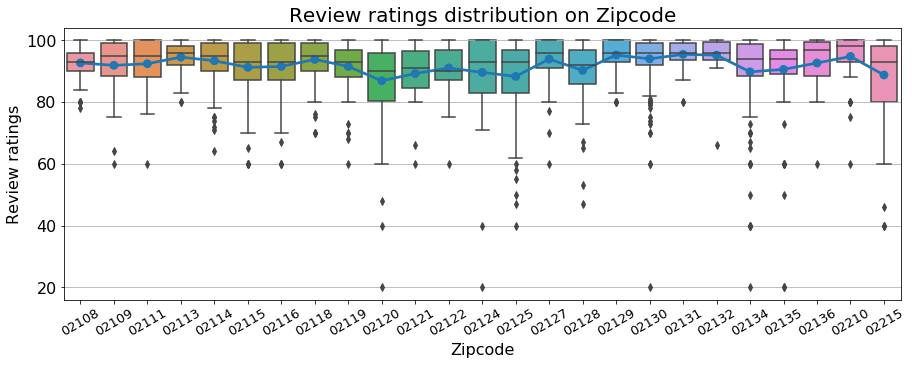

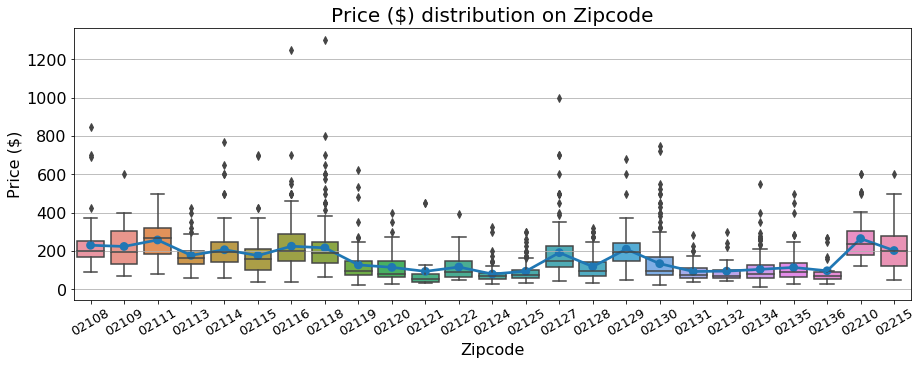

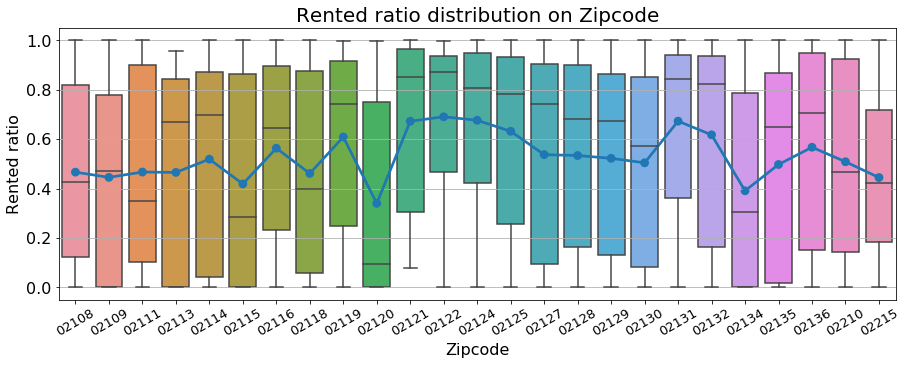

In [31]:
vis_dist(listings_loc, 'zipcode', 'review_scores_rating', 'Zipcode', 'Review ratings')
vis_dist(listings_loc, 'zipcode', 'price', 'Zipcode', 'Price ($)')
vis_dist(listings_loc, 'zipcode', 'non_avail_rate', 'Zipcode', 'Rented ratio')

In [32]:
# Compute the average price, avearge rating, popularity of rentals, and number of listed properties vs. zipcode
listings_loc['total__rating_scores'] = listings_loc['review_scores_rating'] * listings_loc['number_of_reviews']
listings_group_1 = listings_loc.groupby('zipcode')[['total__rating_scores', 'price', 'number_of_reviews']].sum().reset_index()

listings_group_2 = listings_loc.groupby('zipcode')['price'].count().reset_index(name='counts')

listings_group_3 = listings_loc.groupby('zipcode')['non_avail_rate'].mean().reset_index()

listings_group = listings_group_1.merge(listings_group_3, how='left', on='zipcode').merge(listings_group_2, how='left', on='zipcode')

listings_group['avg_price'] = listings_group['price'] / listings_group['counts']
listings_group['avg_rating'] = listings_group['total__rating_scores'] / listings_group['number_of_reviews']

listings_group.drop(['total__rating_scores', 'price', 'number_of_reviews'], axis=1, inplace=True)

In [33]:
# Add back in the coordinates for each zipcode
coords = listings_group.apply(coordinate_to_zipcode, zipcode='zipcode', is_coordinate=False, axis=1)

lat_list = []
lon_list = []
for idx, value in coords.items():
    lat, lon = value
    lat_list.append(lat)
    lon_list.append(lon)
    
listings_group['lat'] = lat_list
listings_group['lon'] = lon_list

listings_group.head(2)

,zipcode,non_avail_rate,counts,avg_price,avg_rating,lat,lon
0,02108,0.466367,67,230.716418,91.925965,42.357711,-71.063649
1,02109,0.445205,36,224.472222,92.212121,42.360073,-71.054879


In [34]:
# Visualize based on zipcode on map
map_Boston = folium.Map(location=[42.321806, -71.089982], tiles='Stamen Terrain', zoom_start=12, prefer_canvas=True)

In [35]:
# Visualize each list
mc = MarkerCluster()

for row in listings_prd.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude, row.longitude],
                               popup='Price: ${0:.1f}\nRating: {1:.2f}\nAvailability:{2:.2f}%'.format(
                                   row.price, row.review_scores_rating, (1 - row.non_avail_rate) * 100)))
    
mc.add_to(map_Boston)

In [36]:
# Visualize the avaraged statistics
for row in listings_group.itertuples():
    folium.Circle(
        location=[row.lat, row.lon],
        radius=row.counts * 2,
        popup='Zipcode: {0}\n# of listings: {1}\nPrice: ${2:.1f}\nRating: {3:.2f}\nAvailability:{4:.2f}%'.format(
            row.zipcode, row.counts, row.avg_price, row.avg_rating, (1 - row.non_avail_rate) * 100),
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map_Boston)
    
map_Boston.save('./figs/Boston_map.html')

In [37]:
map_Boston

# 3. Modeling the Price

In [38]:
# Check the missing values in the dataset
columns_with_null(listings_prd)

,# of Nulls,Null %
property_type,2,0.000722
beds,6,0.002165
bedrooms,7,0.002526
bathrooms,12,0.004331


In [39]:
# Start with the bathrooms with the most missing values
listings_prd[listings_prd['bathrooms'].isnull()]

,price,review_scores_rating,number_of_reviews,non_avail_rate,zipcode,latitude,longitude,host_is_superhost,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,extra_people,availability_30,availability_60,availability_90,availability_365,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
103,85.0,94.0,17,0.989041,02130,42.307574,-71.134630,f,House,Private room,2,NaN,1.0,1.0,Real Bed,1,$0.00,26,56,86,361,f,moderate,f,f
755,99.0,91.0,73,0.821918,02108,42.364824,-71.053707,f,Apartment,Entire home/apt,2,NaN,1.0,NaN,Real Bed,1,$0.00,0,20,46,300,t,strict,f,f
800,167.0,82.0,54,0.898630,02118,42.338140,-71.080008,f,Apartment,Entire home/apt,4,NaN,1.0,1.0,Real Bed,1,$0.00,17,33,53,328,f,strict,f,f
820,60.0,58.0,10,0.997260,02125,42.321037,-71.074579,f,Bed & Breakfast,Private room,2,NaN,1.0,NaN,Real Bed,1,$20.00,29,59,89,364,t,strict,f,f
825,60.0,62.0,14,0.991781,02125,42.318770,-71.077602,f,House,Private room,2,NaN,1.0,NaN,Real Bed,1,$20.00,27,57,87,362,t,flexible,f,f
888,163.0,86.0,65,0.778082,02118,42.339233,-71.081413,f,Apartment,Entire home/apt,4,NaN,1.0,1.0,Real Bed,1,$0.00,4,16,39,284,f,strict,f,f
989,98.0,91.0,184,0.901370,02116,42.346428,-71.075030,f,House,Private room,1,NaN,1.0,1.0,Real Bed,1,$0.00,11,28,54,329,f,moderate,f,f
1120,135.0,88.0,215,0.920548,02116,42.344957,-71.074857,f,Bed & Breakfast,Private room,1,NaN,1.0,1.0,Real Bed,1,$12.00,6,34,61,336,f,moderate,f,f
2196,249.0,100.0,1,0.997260,02115,42.345009,-71.098724,f,Apartment,Private room,3,NaN,1.0,1.0,Real Bed,1,$0.00,29,59,89,364,f,super_strict_30,f,t
2201,349.0,88.0,9,0.997260,02215,42.344865,-71.102600,f,Apartment,Entire home/apt,4,NaN,2.0,2.0,Real Bed,1,$0.00,29,59,89,364,f,super_strict_30,f,t


In [40]:
listings_prd['bathrooms'].value_counts() / listings.shape[0]

1.0    0.598326
2.0    0.093445
1.5    0.047978
2.5    0.015621
3.0    0.004463
3.5    0.003347
0.0    0.002510
0.5    0.001395
6.0    0.001116
5.0    0.000558
4.0    0.000558
4.5    0.000279
Name: bathrooms, dtype: float64

In [41]:
listings_prd['bedrooms'].value_counts() / listings.shape[0]

1.0    0.514086
2.0    0.141980
0.0    0.065551
3.0    0.034868
4.0    0.011158
5.0    0.003347
Name: bedrooms, dtype: float64

We can see that more than half of the listed properties have one bathroon and the ratio of other numbers of bathrooms is all lower than 10%, so we choose to fill the missing values with the mode 1.

In [42]:
listings_prd['bathrooms'].fillna(1, inplace=True)

In [43]:
listings_prd[listings_prd['bedrooms'].isnull()]

,price,review_scores_rating,number_of_reviews,non_avail_rate,zipcode,latitude,longitude,host_is_superhost,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,extra_people,availability_30,availability_60,availability_90,availability_365,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
920,229.0,89.0,9,0.991781,02118,42.342594,-71.079421,f,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,1,$0.00,27,57,87,362,f,super_strict_30,f,t
1117,269.0,91.0,1,0.978082,02118,42.341797,-71.078195,f,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,1,$0.00,24,54,82,357,f,super_strict_30,f,t
1132,225.0,90.0,4,0.978082,02118,42.343210,-71.077760,f,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,2,$0.00,24,54,82,357,f,super_strict_30,f,t
1251,209.0,78.0,22,0.884932,02115,42.349496,-71.085954,f,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,1,$0.00,10,29,48,323,f,super_strict_30,f,t
1366,209.0,87.0,6,0.898630,02115,42.348631,-71.085257,f,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,1,$0.00,11,31,53,328,f,super_strict_30,f,t
1419,209.0,92.0,17,0.882192,02115,42.348317,-71.084743,f,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,1,$0.00,8,28,47,322,f,super_strict_30,f,t
1959,175.0,92.0,127,0.690411,02108,42.358460,-71.063270,f,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,2,$0.00,2,8,8,252,t,strict,f,f


In [44]:
listings_prd[listings_prd['beds'].isnull()]

,price,review_scores_rating,number_of_reviews,non_avail_rate,zipcode,latitude,longitude,host_is_superhost,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,extra_people,availability_30,availability_60,availability_90,availability_365,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
494,99.0,100.0,1,0.063014,02120,42.333072,-71.101286,f,Apartment,Private room,1,1.0,1.0,NaN,Real Bed,1,$50.00,0,0,23,23,f,moderate,f,f
755,99.0,91.0,73,0.821918,02108,42.364824,-71.053707,f,Apartment,Entire home/apt,2,1.0,1.0,NaN,Real Bed,1,$0.00,0,20,46,300,t,strict,f,f
820,60.0,58.0,10,0.997260,02125,42.321037,-71.074579,f,Bed & Breakfast,Private room,2,1.0,1.0,NaN,Real Bed,1,$20.00,29,59,89,364,t,strict,f,f
825,60.0,62.0,14,0.991781,02125,42.318770,-71.077602,f,House,Private room,2,1.0,1.0,NaN,Real Bed,1,$20.00,27,57,87,362,t,flexible,f,f
2819,57.0,87.0,12,0.964384,02124,42.290891,-71.060188,f,House,Private room,2,1.0,1.0,NaN,Real Bed,1,$12.00,17,47,77,352,f,flexible,f,f
2865,60.0,93.0,3,0.980822,02125,42.302353,-71.065605,f,House,Private room,2,1.0,1.0,NaN,Real Bed,1,$20.00,23,53,83,358,t,strict,f,f


In [45]:
listings_prd['beds'].value_counts() / listings.shape[0]

1.0     0.468340
2.0     0.198884
3.0     0.060251
4.0     0.025384
5.0     0.008926
6.0     0.003905
7.0     0.001953
8.0     0.001674
0.0     0.001116
9.0     0.000558
16.0    0.000279
Name: beds, dtype: float64

In [46]:
# Similarly, fill the missing values for bedrooms and beds using 1
listings_prd['bedrooms'].fillna(1, inplace=True)
listings_prd['beds'].fillna(1, inplace=True)

In [47]:
listings_prd[listings_prd['property_type'].isnull()]

,price,review_scores_rating,number_of_reviews,non_avail_rate,zipcode,latitude,longitude,host_is_superhost,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,extra_people,availability_30,availability_60,availability_90,availability_365,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
1321,199.0,85.0,26,0.287671,02116,42.349350,-71.082488,f,NaN,Entire home/apt,2,1.0,0.0,1.0,Real Bed,2,$10.00,16,32,59,105,t,strict,f,f
3393,115.0,60.0,2,0.117808,02134,42.353449,-71.131797,f,NaN,Private room,1,1.0,1.0,1.0,Real Bed,1,$0.00,3,13,43,43,f,moderate,f,f


In [48]:
listings_prd['property_type'].value_counts() / listings.shape[0]

Apartment          0.552022
House              0.133612
Condominium        0.049372
Townhouse          0.012831
Loft               0.008926
Bed & Breakfast    0.008368
Boat               0.003068
Other              0.002510
Villa              0.000558
Dorm               0.000558
Guesthouse         0.000279
Entire Floor       0.000279
Name: property_type, dtype: float64

The two rows with missing values in property_type have only either zero or one bedroom, and the Apartment accounts for more than 50% of the types, so we will fill the missing values for these two rows with Apartment.

In [49]:
listings_prd['property_type'].fillna('Apartment', inplace=True)

In [50]:
# Check the missing values
columns_with_null(listings_prd)

,# of Nulls,Null %


In [51]:
# Check the types of the columns
listings_prd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2771 entries, 1 to 3583
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   price                             2771 non-null   float64
 1   review_scores_rating              2771 non-null   float64
 2   number_of_reviews                 2771 non-null   int64  
 3   non_avail_rate                    2771 non-null   float64
 4   zipcode                           2771 non-null   object 
 5   latitude                          2771 non-null   float64
 6   longitude                         2771 non-null   float64
 7   host_is_superhost                 2771 non-null   object 
 8   property_type                     2771 non-null   object 
 9   room_type                         2771 non-null   object 
 10  accommodates                      2771 non-null   int64  
 11  bathrooms                         2771 non-null   float64
 12  bedroo